# PaBiRoboy dynamic equations

First, import the necessary functions from SymPy that will allow us to construct time varying vectors in the reference frames.

In [88]:
from __future__ import print_function, division
from sympy import symbols, simplify, Matrix
from sympy import trigsimp
from sympy.physics.mechanics import dynamicsymbols, ReferenceFrame, Point, inertia, RigidBody, KanesMethod
from numpy import deg2rad, rad2deg, array, zeros, linspace
from sympy.physics.vector import init_vprinting, vlatex
import numpy as np

SymPy has a rich printing system. Here we initialize printing so that all of the mathematical equations are rendered in standard mathematical notation.

In [2]:
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex='mathjax', pretty_print=False)

## Interial frames

In [3]:
inertial_frame = ReferenceFrame('I')
lower_leg_left_frame = ReferenceFrame('R_1')
upper_leg_left_frame = ReferenceFrame('R_2')
hip_frame = ReferenceFrame('R_3')
upper_leg_right_frame = ReferenceFrame('R_4')
lower_leg_right_frame = ReferenceFrame('R_5')

## Angles

In [4]:
theta0, theta1, theta2, theta3, theta4, theta5 = dynamicsymbols('theta0, theta1, theta2, theta3, theta4, theta5')

In [5]:
lower_leg_left_frame.orient(inertial_frame, 'Axis', (theta0, inertial_frame.z))
lower_leg_left_frame.dcm(inertial_frame)

Matrix([
[ cos(theta0), sin(theta0), 0],
[-sin(theta0), cos(theta0), 0],
[           0,           0, 1]])

In [6]:
upper_leg_left_frame.orient(lower_leg_left_frame, 'Axis', (theta1, lower_leg_left_frame.z))
simplify(upper_leg_left_frame.dcm(inertial_frame))

Matrix([
[ cos(theta0 + theta1), sin(theta0 + theta1), 0],
[-sin(theta0 + theta1), cos(theta0 + theta1), 0],
[                    0,                    0, 1]])

In [7]:
hip_frame.orient(upper_leg_left_frame, 'Axis', (theta2, upper_leg_left_frame.z))
simplify(hip_frame.dcm(inertial_frame))

Matrix([
[ cos(theta0 + theta1 + theta2), sin(theta0 + theta1 + theta2), 0],
[-sin(theta0 + theta1 + theta2), cos(theta0 + theta1 + theta2), 0],
[                             0,                             0, 1]])

In [8]:
upper_leg_right_frame.orient(hip_frame, 'Axis', (theta3, hip_frame.z))
simplify(upper_leg_right_frame.dcm(inertial_frame))

Matrix([
[ cos(theta0 + theta1 + theta2 + theta3), sin(theta0 + theta1 + theta2 + theta3), 0],
[-sin(theta0 + theta1 + theta2 + theta3), cos(theta0 + theta1 + theta2 + theta3), 0],
[                                      0,                                      0, 1]])

In [9]:
lower_leg_right_frame.orient(upper_leg_right_frame, 'Axis', (theta4, upper_leg_right_frame.z))
simplify(lower_leg_right_frame.dcm(inertial_frame))

Matrix([
[ cos(theta0 + theta1 + theta2 + theta3 + theta4), sin(theta0 + theta1 + theta2 + theta3 + theta4), 0],
[-sin(theta0 + theta1 + theta2 + theta3 + theta4), cos(theta0 + theta1 + theta2 + theta3 + theta4), 0],
[                                               0,                                               0, 1]])

## Points and Locations

In [10]:
ankle_left = Point('AnkleLeft')
knee_left = Point('KneeLeft')
hip_left = Point('HipLeft')
hip_right = Point('HipRight')
knee_right = Point('KneeRight')
ankle_right = Point('AnkleRight')

In [11]:
lower_leg_length, upper_leg_length, hip_length = symbols('l1, l2, l3')

In [12]:
knee_left.set_pos(ankle_left, lower_leg_length * lower_leg_left_frame.y)
knee_left.pos_from(ankle_left).express(inertial_frame).simplify()

- l1*sin(theta0)*I.x + l1*cos(theta0)*I.y

In [13]:
hip_left.set_pos(knee_left, upper_leg_length * upper_leg_left_frame.y)
hip_left.pos_from(ankle_left).express(inertial_frame).simplify()

(-l1*sin(theta0) - l2*sin(theta0 + theta1))*I.x + (l1*cos(theta0) + l2*cos(theta0 + theta1))*I.y

In [14]:
hip_right.set_pos(hip_left, hip_length * hip_frame.y)
hip_right.pos_from(ankle_left).express(inertial_frame).simplify()

(-l1*sin(theta0) - l2*sin(theta0 + theta1) - l3*sin(theta0 + theta1 + theta2))*I.x + (l1*cos(theta0) + l2*cos(theta0 + theta1) + l3*cos(theta0 + theta1 + theta2))*I.y

In [15]:
knee_right.set_pos(hip_right, upper_leg_length * upper_leg_right_frame.y)
knee_right.pos_from(ankle_left).express(inertial_frame).simplify()

(-l1*sin(theta0) - l2*sin(theta0 + theta1) - l2*sin(theta0 + theta1 + theta2 + theta3) - l3*sin(theta0 + theta1 + theta2))*I.x + (l1*cos(theta0) + l2*cos(theta0 + theta1) + l2*cos(theta0 + theta1 + theta2 + theta3) + l3*cos(theta0 + theta1 + theta2))*I.y

In [16]:
ankle_right.set_pos(knee_right, lower_leg_length * lower_leg_right_frame.y)
ankle_right.pos_from(ankle_left).express(inertial_frame).simplify()

(-l1*sin(theta0 + theta1 + theta2 + theta3 + theta4) - l1*sin(theta0) - l2*sin(theta0 + theta1) - l2*sin(theta0 + theta1 + theta2 + theta3) - l3*sin(theta0 + theta1 + theta2))*I.x + (l1*cos(theta0 + theta1 + theta2 + theta3 + theta4) + l1*cos(theta0) + l2*cos(theta0 + theta1) + l2*cos(theta0 + theta1 + theta2 + theta3) + l3*cos(theta0 + theta1 + theta2))*I.y

In [17]:
lower_leg_left_com_length = lower_leg_length/2
upper_leg_left_com_length = upper_leg_length/2
hip_com_length = hip_length/2
upper_leg_right_com_length = upper_leg_length/2
lower_leg_right_com_length = lower_leg_length/2

lower_leg_left_mass_center = Point('L_COMleft')
upper_leg_left_mass_center = Point('U_COMleft')
hip_mass_center = Point('H_COMleft')
upper_leg_right_mass_center = Point('U_COMright')
lower_leg_right_mass_center = Point('L_COMright')

In [18]:
lower_leg_left_mass_center.set_pos(ankle_left, lower_leg_left_com_length * lower_leg_left_frame.y)
lower_leg_left_mass_center.pos_from(ankle_left).express(inertial_frame).simplify()

- l1*sin(theta0)/2*I.x + l1*cos(theta0)/2*I.y

In [19]:
upper_leg_left_mass_center.set_pos(knee_left, upper_leg_left_com_length * upper_leg_left_frame.y)
upper_leg_left_mass_center.pos_from(ankle_left).express(inertial_frame).simplify()

(-l1*sin(theta0) - l2*sin(theta0 + theta1)/2)*I.x + (l1*cos(theta0) + l2*cos(theta0 + theta1)/2)*I.y

In [20]:
hip_mass_center.set_pos(hip_left, hip_com_length * hip_frame.y)
hip_mass_center.pos_from(ankle_left).express(inertial_frame).simplify()

(-l1*sin(theta0) - l2*sin(theta0 + theta1) - l3*sin(theta0 + theta1 + theta2)/2)*I.x + (l1*cos(theta0) + l2*cos(theta0 + theta1) + l3*cos(theta0 + theta1 + theta2)/2)*I.y

In [21]:
upper_leg_right_mass_center.set_pos(hip_right, upper_leg_right_com_length * upper_leg_right_frame.y)
upper_leg_right_mass_center.pos_from(ankle_left).express(inertial_frame).simplify()

(-l1*sin(theta0) - l2*sin(theta0 + theta1) - l2*sin(theta0 + theta1 + theta2 + theta3)/2 - l3*sin(theta0 + theta1 + theta2))*I.x + (l1*cos(theta0) + l2*cos(theta0 + theta1) + l2*cos(theta0 + theta1 + theta2 + theta3)/2 + l3*cos(theta0 + theta1 + theta2))*I.y

In [22]:
lower_leg_right_mass_center.set_pos(knee_right, lower_leg_right_com_length * lower_leg_right_frame.y)
lower_leg_right_mass_center.pos_from(ankle_left).express(inertial_frame).simplify()

(-l1*sin(theta0 + theta1 + theta2 + theta3 + theta4)/2 - l1*sin(theta0) - l2*sin(theta0 + theta1) - l2*sin(theta0 + theta1 + theta2 + theta3) - l3*sin(theta0 + theta1 + theta2))*I.x + (l1*cos(theta0 + theta1 + theta2 + theta3 + theta4)/2 + l1*cos(theta0) + l2*cos(theta0 + theta1) + l2*cos(theta0 + theta1 + theta2 + theta3) + l3*cos(theta0 + theta1 + theta2))*I.y

## Kinematical Differential Equations

In [23]:
omega0, omega1, omega2, omega3, omega4 = dynamicsymbols('omega0, omega1, omega2, omega3, omega4')
kinematical_differential_equations = [omega0 - theta0.diff(),
                                      omega1 - theta1.diff(),
                                      omega2 - theta2.diff(),
                                      omega3 - theta3.diff(),
                                      omega4 - theta4.diff(),]

kinematical_differential_equations

[omega0 - theta0', omega1 - theta1', omega2 - theta2', omega3 - theta3', omega4 - theta4']

## Angular Velocities

In [24]:
lower_leg_left_frame.set_ang_vel(inertial_frame,         omega0 * inertial_frame.z)
lower_leg_left_frame.ang_vel_in(inertial_frame)

omega0*I.z

In [25]:
upper_leg_left_frame.set_ang_vel(lower_leg_left_frame,   omega1     * inertial_frame.z)
upper_leg_left_frame.ang_vel_in(inertial_frame)

(omega0 + omega1)*I.z

In [26]:
hip_frame.set_ang_vel(upper_leg_left_frame,              omega2     * inertial_frame.z)
hip_frame.ang_vel_in(inertial_frame)

(omega0 + omega1 + omega2)*I.z

In [27]:
upper_leg_right_frame.set_ang_vel(hip_frame,             omega3     * inertial_frame.z)
upper_leg_right_frame.ang_vel_in(inertial_frame)

(omega0 + omega1 + omega2 + omega3)*I.z

In [28]:
lower_leg_right_frame.set_ang_vel(upper_leg_right_frame, omega4     * inertial_frame.z)
lower_leg_right_frame.ang_vel_in(inertial_frame)

(omega0 + omega1 + omega2 + omega3 + omega4)*I.z

# Linear Velocities

Finally, the linear velocities of the mass centers are needed. Starting at the ankle which has a velocity of 0.

In [29]:
ankle_left.set_vel(inertial_frame, 0)

Working our way up the chain we can make use of the fact that the joint points are located on two rigid bodies. Any fixed point in a reference frame can be computed if the linear velocity of another point on that frame is known and the frame's angular velocity is known.

$$^I\mathbf{v}^{P_2} = ^I\mathbf{v}^{P_1} + ^I\omega^A \times \mathbf{r}^{\frac{P_2}{P_1}}$$

The `Point.v2pt_theory()` method makes it easy to do this calculation.

In [30]:
lower_leg_left_mass_center.v2pt_theory(ankle_left, inertial_frame, lower_leg_left_frame)
lower_leg_left_mass_center.vel(inertial_frame)

- l1*omega0/2*R_1.x

In [31]:
knee_left.v2pt_theory(ankle_left, inertial_frame, lower_leg_left_frame)
knee_left.vel(inertial_frame)

- l1*omega0*R_1.x

In [32]:
upper_leg_left_mass_center.v2pt_theory(knee_left, inertial_frame, upper_leg_left_frame)
upper_leg_left_mass_center.vel(inertial_frame)

- l1*omega0*R_1.x - l2*(omega0 + omega1)/2*R_2.x

In [33]:
hip_left.v2pt_theory(knee_left, inertial_frame, upper_leg_left_frame)
hip_left.vel(inertial_frame)

- l1*omega0*R_1.x - l2*(omega0 + omega1)*R_2.x

In [34]:
hip_mass_center.v2pt_theory(hip_left, inertial_frame, hip_frame)
hip_mass_center.vel(inertial_frame)

- l1*omega0*R_1.x - l2*(omega0 + omega1)*R_2.x - l3*(omega0 + omega1 + omega2)/2*R_3.x

In [35]:
hip_right.v2pt_theory(hip_left, inertial_frame, hip_frame)
hip_right.vel(inertial_frame)

- l1*omega0*R_1.x - l2*(omega0 + omega1)*R_2.x - l3*(omega0 + omega1 + omega2)*R_3.x

In [36]:
knee_right.v2pt_theory(hip_right, inertial_frame, upper_leg_right_frame)
knee_right.vel(inertial_frame)

- l1*omega0*R_1.x - l2*(omega0 + omega1)*R_2.x - l3*(omega0 + omega1 + omega2)*R_3.x - l2*(omega0 + omega1 + omega2 + omega3)*R_4.x

In [37]:
upper_leg_right_mass_center.v2pt_theory(knee_right, inertial_frame, upper_leg_right_frame)
upper_leg_right_mass_center.vel(inertial_frame)

- l1*omega0*R_1.x - l2*(omega0 + omega1)*R_2.x - l3*(omega0 + omega1 + omega2)*R_3.x - l2*(omega0 + omega1 + omega2 + omega3)/2*R_4.x

In [38]:
ankle_right.v2pt_theory(knee_right, inertial_frame, lower_leg_right_frame)
ankle_right.vel(inertial_frame)

- l1*omega0*R_1.x - l2*(omega0 + omega1)*R_2.x - l3*(omega0 + omega1 + omega2)*R_3.x - l2*(omega0 + omega1 + omega2 + omega3)*R_4.x - l1*(omega0 + omega1 + omega2 + omega3 + omega4)*R_5.x

In [39]:
lower_leg_right_mass_center.v2pt_theory(knee_right, inertial_frame, lower_leg_right_frame)
lower_leg_right_mass_center.vel(inertial_frame)

- l1*omega0*R_1.x - l2*(omega0 + omega1)*R_2.x - l3*(omega0 + omega1 + omega2)*R_3.x - l2*(omega0 + omega1 + omega2 + omega3)*R_4.x - l1*(omega0 + omega1 + omega2 + omega3 + omega4)/2*R_5.x

# Masses, Inertia, Rigid Bodies

In [40]:
lower_leg_mass, upper_leg_mass, hip_mass = symbols('m_L, m_U, m_H')

In [41]:
lower_leg_inertia, upper_leg_inertia, hip_inertia = symbols('I_Lz, I_Uz, I_Hz')

In [42]:
lower_leg_left_inertia_dyadic = inertia(lower_leg_left_frame, 0, 0, lower_leg_inertia)
lower_leg_left_central_inertia = (lower_leg_left_inertia_dyadic, lower_leg_left_mass_center)
lower_leg_left_inertia_dyadic.to_matrix(lower_leg_left_frame)

Matrix([
[0, 0,    0],
[0, 0,    0],
[0, 0, I_Lz]])

In [43]:
upper_leg_left_inertia_dyadic = inertia(upper_leg_left_frame, 0, 0, upper_leg_inertia)
upper_leg_left_central_inertia = (upper_leg_left_inertia_dyadic, upper_leg_left_mass_center)
upper_leg_left_inertia_dyadic.to_matrix(upper_leg_left_frame)

Matrix([
[0, 0,    0],
[0, 0,    0],
[0, 0, I_Uz]])

In [44]:
hip_inertia_dyadic = inertia(hip_frame, 0, 0, hip_inertia)
hip_central_inertia = (hip_inertia_dyadic, hip_mass_center)
hip_inertia_dyadic.to_matrix(hip_frame)

Matrix([
[0, 0,    0],
[0, 0,    0],
[0, 0, I_Hz]])

In [45]:
upper_leg_right_inertia_dyadic = inertia(upper_leg_right_frame, 0, 0, upper_leg_inertia)
upper_leg_right_central_inertia = (upper_leg_right_inertia_dyadic, upper_leg_right_mass_center)
upper_leg_right_inertia_dyadic.to_matrix(upper_leg_right_frame)

Matrix([
[0, 0,    0],
[0, 0,    0],
[0, 0, I_Uz]])

In [46]:
lower_leg_right_inertia_dyadic = inertia(lower_leg_right_frame, 0, 0, lower_leg_inertia)
lower_leg_right_central_inertia = (lower_leg_right_inertia_dyadic, lower_leg_right_mass_center)
lower_leg_right_inertia_dyadic.to_matrix(lower_leg_right_frame)

Matrix([
[0, 0,    0],
[0, 0,    0],
[0, 0, I_Lz]])

In [47]:
lower_leg_left = RigidBody('Lower Leg Left', lower_leg_left_mass_center, lower_leg_left_frame,
                      lower_leg_mass, lower_leg_left_central_inertia)

In [48]:
upper_leg_left = RigidBody('Upper Leg Left', upper_leg_left_mass_center, upper_leg_left_frame,
                      upper_leg_mass, upper_leg_left_central_inertia)

In [49]:
hip = RigidBody('Hip', hip_mass_center, hip_frame, hip_mass, hip_central_inertia)

In [50]:
upper_leg_right = RigidBody('Upper Leg Right', upper_leg_right_mass_center, upper_leg_right_frame,
                      upper_leg_mass, upper_leg_right_central_inertia)

In [51]:
lower_leg_right = RigidBody('Lower Leg Right', lower_leg_right_mass_center, lower_leg_right_frame,
                      lower_leg_mass, lower_leg_right_central_inertia)

# Forces and Torques

In [52]:
g = symbols('g')

In [53]:
lower_leg_left_grav_force = (lower_leg_left_mass_center, -lower_leg_mass * g * inertial_frame.y)
upper_leg_left_grav_force = (upper_leg_left_mass_center, -upper_leg_mass * g * inertial_frame.y)
hip_grav_force = (hip_mass_center, -hip_mass * g * inertial_frame.y)
upper_leg_right_grav_force = (upper_leg_right_mass_center, -upper_leg_mass * g * inertial_frame.y)
lower_leg_right_grav_force = (lower_leg_right_mass_center, -lower_leg_mass * g * inertial_frame.y)

In [54]:
ankle_torque0, knee_torque0, hip_torque0, hip_torque1, knee_torque1, ankle_torque1 = dynamicsymbols('T_a0, T_k0, T_h0, T_h1, T_k1, T_a1')

In [55]:
lower_leg_left_torque_vector = ankle_torque0 * inertial_frame.z - knee_torque0 * inertial_frame.z
upper_leg_left_torque_vector = knee_torque0 * inertial_frame.z - hip_torque0 * inertial_frame.z
hip_left_torque_vector = hip_torque0 * inertial_frame.z - hip_torque1 * inertial_frame.z
hip_right_torque_vector = hip_torque1 * inertial_frame.z - knee_torque1 * inertial_frame.z
upper_leg_right_torque_vector = knee_torque1 * inertial_frame.z - ankle_torque1 * inertial_frame.z
lower_leg_right_torque_vector = ankle_torque1 * inertial_frame.z

In [56]:
lower_leg_left_torque = (lower_leg_left_frame, lower_leg_left_torque_vector)
upper_leg_left_torque = (upper_leg_left_frame, upper_leg_left_torque_vector)
hip_left_torque = (hip_frame, hip_left_torque_vector)
hip_right_torque = (hip_frame, hip_right_torque_vector)
upper_leg_right_torque = (upper_leg_right_frame, upper_leg_right_torque_vector)
lower_leg_right_torque = (lower_leg_right_frame, lower_leg_right_torque_vector)

# Equations of Motion

In [57]:
coordinates = [theta0, theta1, theta2, theta3, theta4]
coordinates

[theta0, theta1, theta2, theta3, theta4]

In [58]:
speeds = [omega0, omega1, omega2, omega3, omega4]
speeds

[omega0, omega1, omega2, omega3, omega4]

In [59]:
kinematical_differential_equations

[omega0 - theta0', omega1 - theta1', omega2 - theta2', omega3 - theta3', omega4 - theta4']

In [60]:
kane = KanesMethod(inertial_frame, coordinates, speeds, kinematical_differential_equations)

In [61]:
loads = [lower_leg_left_grav_force,
         upper_leg_left_grav_force,
         hip_grav_force, 
         upper_leg_right_grav_force,
         lower_leg_right_grav_force,
         lower_leg_left_torque,
         upper_leg_left_torque,
         hip_left_torque,
         hip_right_torque,
         upper_leg_right_torque,
         lower_leg_right_torque]
loads

[(L_COMleft, - g*m_L*I.y),
 (U_COMleft, - g*m_U*I.y),
 (H_COMleft, - g*m_H*I.y),
 (U_COMright, - g*m_U*I.y),
 (L_COMright, - g*m_L*I.y),
 (R_1, (T_a0 - T_k0)*I.z),
 (R_2, (-T_h0 + T_k0)*I.z),
 (R_3, (T_h0 - T_h1)*I.z),
 (R_3, (T_h1 - T_k1)*I.z),
 (R_4, (-T_a1 + T_k1)*I.z),
 (R_5, T_a1*I.z)]

In [62]:
bodies = [lower_leg_left, upper_leg_left, hip, upper_leg_right, lower_leg_right]
bodies

[Lower Leg Left, Upper Leg Left, Hip, Upper Leg Right, Lower Leg Right]

In [63]:
fr, frstar = kane.kanes_equations(loads, bodies)

In [64]:
#trigsimp(fr + frstar)

Keep in mind that out utlimate goal is to have the equations of motion in first order form:

$$ \dot{\mathbf{x}} = \mathbf{g}(\mathbf{x}, t) $$

The equations of motion are linear in terms of the derivatives of the generalized speeds and the `KanesMethod` class automatically puts the equations in a more useful form for the next step of numerical simulation:

$$ \mathbf{M}(\mathbf{x}, t)\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, t) $$

Note that

$$ \mathbf{g} = \mathbf{M}^{-1}(\mathbf{x}, t) \mathbf{f}(\mathbf{x}, t) $$

and that $\mathbf{g}$ can be computed analytically but for non-toy problems, it is best to do this numerically. So we will simply generate the $\mathbf{M}$ and $\mathbf{f}$ matrices for later use.

The mass matrix, $\mathbf{M}$, can be accessed with the `mass_matrix` method (use `mass_matrix_full` to include the kinematical differential equations too. We can use `trigsimp` again to make this relatively compact: 

In [65]:
mass_matrix = trigsimp(kane.mass_matrix_full)
mass_matrix

Matrix([
[1, 0, 0, 0, 0,                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             0,                                                                                                                                                                                                                                                                 

The right hand side, $\mathbf{f}$, is a vector function of all the non-inertial forces (gyroscopic, external, coriolis, etc):

In [66]:
forcing_vector = trigsimp(kane.forcing_full)
forcing_vector

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

# Simulation

In [67]:
from scipy.integrate import odeint
from pydy.codegen.ode_function_generators import generate_ode_function
%matplotlib inline
from matplotlib.pyplot import plot, legend, xlabel, ylabel, rcParams
rcParams['figure.figsize'] = (14.0, 6.0)

In [68]:
constants = [lower_leg_length,
             upper_leg_length,
             hip_length,
             
             lower_leg_left_com_length,
             upper_leg_left_com_length,
             hip_com_length,
             upper_leg_right_com_length,
             lower_leg_right_com_length,
             
             lower_leg_mass,
             upper_leg_mass,
             hip_mass,
             
             lower_leg_inertia,
             upper_leg_inertia,
             hip_inertia,
             
             g]
constants

[l1, l2, l3, l1/2, l2/2, l3/2, l2/2, l1/2, m_L, m_U, m_H, I_Lz, I_Uz, I_Hz, g]

In [69]:
numerical_constants = array([0.42,  # lower_leg_length [m]
                             0.54, # upper_leg_length [m]
                             0.2, # hip_length
                             
                             0.21,  # lower_leg_com_length [m]
                             0.27,  # upper_leg_com_length
                             0.10,  # hip_com_length
                             0.27,  # upper_leg_com_length
                             0.21,  # lower_leg_com_length [m]
                             
                             1.0,  # lower_leg_mass [kg]
                             1.5,  # upper_leg_mass [kg]
                             2.0,  # hip_mass [kg]
                             
                             0.1,  # lower_leg_inertia [kg*m^2]                             
                             0.2,  # upper_leg_inertia [kg*m^2]
                             0.1,  # hip_inertia [kg*m^2]
                             
                             9.81],  # acceleration due to gravity [m/s^2]
                            ) 
numerical_constants

array([ 0.42,  0.54,  0.2 ,  0.21,  0.27,  0.1 ,  0.27,  0.21,  1.  ,
        1.5 ,  2.  ,  0.1 ,  0.2 ,  0.1 ,  9.81])

In [70]:
coordinates = [theta0, theta1, theta2, theta3, theta4]
coordinates

[theta0, theta1, theta2, theta3, theta4]

In [71]:
speeds = [omega0, omega1, omega2, omega3, omega4]
speeds

[omega0, omega1, omega2, omega3, omega4]

In [72]:
specified = [ankle_torque0, knee_torque0, hip_torque0, hip_torque1, knee_torque1, ankle_torque1]

In [73]:
right_hand_side = generate_ode_function(forcing_vector, coordinates,
                                        speeds, constants,
                                        mass_matrix=mass_matrix,
                                        specifieds=specified)

In [74]:
x0 = zeros(10)
x0

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [75]:
x0[0] = deg2rad(60)
x0[1] = deg2rad(-30)
x0[2] = deg2rad(-30)
x0[3] = deg2rad(-30)
x0[4] = deg2rad(-30)
x0

array([ 1.04719755, -0.52359878, -0.52359878, -0.52359878, -0.52359878,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [76]:
numerical_specified = zeros(6)

args = {'constants': numerical_constants,
        'specified': numerical_specified}
frames_per_sec = 60
final_time = 5.0

t = linspace(0.0, final_time, final_time * frames_per_sec)

In [77]:
right_hand_side(x0, 0.0, numerical_specified, numerical_constants)

/usr/local/lib/python2.7/dist-packages/pydy-0.5.0.dev0-py2.7.egg/pydy/codegen/ode_function_generators.py:370: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._constants_values[i] = p[c]


array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  24.38930964, -29.60348457,  -0.41358456,
         1.9175048 ,   2.14208393])

In [78]:
y = odeint(right_hand_side, x0, t, args=(numerical_specified, numerical_constants))
y.shape

(300, 10)

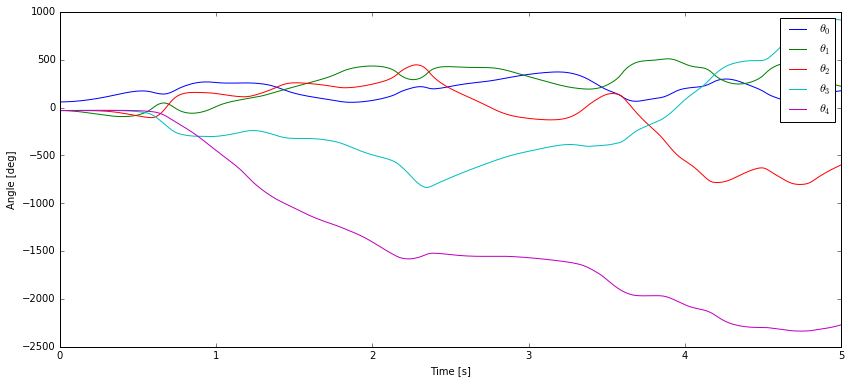

In [79]:
plot(t, rad2deg(y[:, :5]))
xlabel('Time [s]')
ylabel('Angle [deg]')
legend(["${}$".format(vlatex(c)) for c in coordinates])

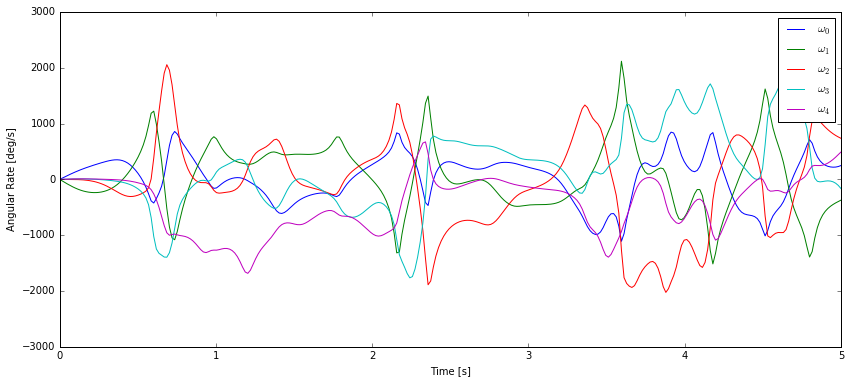

In [80]:
plot(t, rad2deg(y[:, 5:]))
xlabel('Time [s]')
ylabel('Angular Rate [deg/s]')
legend(["${}$".format(vlatex(s)) for s in speeds])

# Visualization

In [81]:
import rospy
from visualization_msgs.msg import Marker
from geometry_msgs.msg import Point

In [82]:
rospy.init_node('PaBiRoboy_dynamics', anonymous=False)

visualization_pub = rospy.Publisher('/visualization_marker', Marker, queue_size=1)
msg = Marker()
msg.header.frame_id = "world"
msg.header.stamp = rospy.Time.now()
msg.type = Marker.ARROW
msg.scale.x = 0.005
msg.scale.y = 0.05
msg.scale.z = 0.05
msg.color.a = 0.5
msg.color.r = 1.0
msg.color.g = 0.0
msg.color.b = 0.0

In [83]:
ankle_left_pos_equation = ankle_left.pos_from(ankle_left).express(inertial_frame).simplify()
knee_left_pos_equation = knee_left.pos_from(ankle_left).express(inertial_frame).simplify()
hip_left_pos_equation = hip_left.pos_from(ankle_left).express(inertial_frame).simplify()
hip_right_pos_equation = hip_right.pos_from(ankle_left).express(inertial_frame).simplify()
knee_right_pos_equation = knee_right.pos_from(ankle_left).express(inertial_frame).simplify()
ankle_right_pos_equation = ankle_right.pos_from(ankle_left).express(inertial_frame).simplify()

In [86]:
for i in range(0,int(final_time * frames_per_sec)):#
    values = {lower_leg_length: 0.4, upper_leg_length: 0.54, hip_length: 0.2, theta0: y[i, 0], theta1: y[i, 1], theta2: y[i, 2], theta3: y[i, 3], theta4: y[i, 4]}
    
    ankle_left_pos = ankle_left_pos_equation.subs(values).to_matrix(inertial_frame)
    knee_left_pos = knee_left_pos_equation.subs(values).to_matrix(inertial_frame)
    hip_left_pos = hip_left_pos_equation.subs(values).to_matrix(inertial_frame)
    hip_right_pos = hip_right_pos_equation.subs(values).to_matrix(inertial_frame)
    knee_right_pos = knee_right_pos_equation.subs(values).to_matrix(inertial_frame)
    ankle_right_pos = ankle_right_pos_equation.subs(values).to_matrix(inertial_frame)
    
    msg.id = 0
    del msg.points[:]
    msg.points.append(Point(ankle_left_pos[0],ankle_left_pos[1],ankle_left_pos[2]))
    msg.points.append(Point(knee_left_pos[0],knee_left_pos[1],knee_left_pos[2]))
    visualization_pub.publish(msg)
    
    msg.id = 1
    del msg.points[:]
    msg.points.append(Point(knee_left_pos[0],knee_left_pos[1],knee_left_pos[2]))
    msg.points.append(Point(hip_left_pos[0],hip_left_pos[1],hip_left_pos[2]))
    visualization_pub.publish(msg)
    
    msg.id = 2
    del msg.points[:]
    msg.points.append(Point(hip_left_pos[0],hip_left_pos[1],hip_left_pos[2]))
    msg.points.append(Point(hip_right_pos[0],hip_right_pos[1],hip_right_pos[2]))
    visualization_pub.publish(msg)
    
    msg.id = 3
    del msg.points[:]
    msg.points.append(Point(hip_right_pos[0],hip_right_pos[1],hip_right_pos[2]))
    msg.points.append(Point(knee_right_pos[0],knee_right_pos[1],knee_right_pos[2]))
    visualization_pub.publish(msg)
    
    msg.id = 4
    del msg.points[:]
    msg.points.append(Point(knee_right_pos[0],knee_right_pos[1],knee_right_pos[2]))
    msg.points.append(Point(ankle_right_pos[0],ankle_right_pos[1],ankle_right_pos[2]))
    visualization_pub.publish(msg)
    


# Jacobian

#### We want to control the hip com position. The hip com seen from ankle_left in inertial_frame is:

In [149]:
F0 = ankle_left.pos_from(hip_mass_center).express(inertial_frame).simplify().to_matrix(inertial_frame)
F0 = Matrix([F0[0], F0[1]])
F0

Matrix([
[ l1*sin(theta0) + l2*sin(theta0 + theta1) + l3*sin(theta0 + theta1 + theta2)/2],
[-l1*cos(theta0) - l2*cos(theta0 + theta1) - l3*cos(theta0 + theta1 + theta2)/2]])

In [151]:
J_hipCOM = F0.jacobian([theta0, theta1, theta2, theta3, theta4])
J_hipCOM

Matrix([
[l1*cos(theta0) + l2*cos(theta0 + theta1) + l3*cos(theta0 + theta1 + theta2)/2, l2*cos(theta0 + theta1) + l3*cos(theta0 + theta1 + theta2)/2, l3*cos(theta0 + theta1 + theta2)/2, 0, 0],
[l1*sin(theta0) + l2*sin(theta0 + theta1) + l3*sin(theta0 + theta1 + theta2)/2, l2*sin(theta0 + theta1) + l3*sin(theta0 + theta1 + theta2)/2, l3*sin(theta0 + theta1 + theta2)/2, 0, 0]])

#### We want to constraint the ankle_right stay at the initial step size

In [152]:
step_length = symbols('L')

In [153]:
F1 = ankle_right.pos_from(ankle_left).express(inertial_frame).simplify().to_matrix(inertial_frame)
F1 = Matrix([F1[0], F1[1]])
F1

Matrix([
[-l1*sin(theta0 + theta1 + theta2 + theta3 + theta4) - l1*sin(theta0) - l2*sin(theta0 + theta1) - l2*sin(theta0 + theta1 + theta2 + theta3) - l3*sin(theta0 + theta1 + theta2)],
[ l1*cos(theta0 + theta1 + theta2 + theta3 + theta4) + l1*cos(theta0) + l2*cos(theta0 + theta1) + l2*cos(theta0 + theta1 + theta2 + theta3) + l3*cos(theta0 + theta1 + theta2)]])

In [154]:
offset = Matrix([step_length, F0[1]])
offset

Matrix([
[                                                                             L],
[-l1*cos(theta0) - l2*cos(theta0 + theta1) - l3*cos(theta0 + theta1 + theta2)/2]])

In [155]:
constraint = F1 - offset
J_ankleRight = constraint.jacobian([theta0, theta1, theta2, theta3, theta4])
J_ankleRight

Matrix([
[        -l1*cos(theta0 + theta1 + theta2 + theta3 + theta4) - l1*cos(theta0) - l2*cos(theta0 + theta1) - l2*cos(theta0 + theta1 + theta2 + theta3) - l3*cos(theta0 + theta1 + theta2),       -l1*cos(theta0 + theta1 + theta2 + theta3 + theta4) - l2*cos(theta0 + theta1) - l2*cos(theta0 + theta1 + theta2 + theta3) - l3*cos(theta0 + theta1 + theta2),     -l1*cos(theta0 + theta1 + theta2 + theta3 + theta4) - l2*cos(theta0 + theta1 + theta2 + theta3) - l3*cos(theta0 + theta1 + theta2), -l1*cos(theta0 + theta1 + theta2 + theta3 + theta4) - l2*cos(theta0 + theta1 + theta2 + theta3), -l1*cos(theta0 + theta1 + theta2 + theta3 + theta4)],
[-l1*sin(theta0 + theta1 + theta2 + theta3 + theta4) - 2*l1*sin(theta0) - 2*l2*sin(theta0 + theta1) - l2*sin(theta0 + theta1 + theta2 + theta3) - 3*l3*sin(theta0 + theta1 + theta2)/2, -l1*sin(theta0 + theta1 + theta2 + theta3 + theta4) - 2*l2*sin(theta0 + theta1) - l2*sin(theta0 + theta1 + theta2 + theta3) - 3*l3*sin(theta0 + theta1 + theta2)/2, -l1*sin(

In [156]:
J = J_hipCOM.col_join(J_ankleRight)
J

Matrix([
[                                                                                                        l1*cos(theta0) + l2*cos(theta0 + theta1) + l3*cos(theta0 + theta1 + theta2)/2,                                                                                                       l2*cos(theta0 + theta1) + l3*cos(theta0 + theta1 + theta2)/2,                                                                                                     l3*cos(theta0 + theta1 + theta2)/2,                                                                                               0,                                                   0],
[                                                                                                        l1*sin(theta0) + l2*sin(theta0 + theta1) + l3*sin(theta0 + theta1 + theta2)/2,                                                                                                       l2*sin(theta0 + theta1) + l3*sin(theta0 + theta1 + theta2)/2,         

In [166]:
J.subs(values).pinv()

Matrix([
[-2.46282216864513,  3.19961586857846, -0.445769063172015,  -0.35537241917395],
[ 5.62262448427497, -3.60102123826841,   1.01769103788041,  0.811315445557625],
[-3.01109099021039,  -4.1206392316851,  -2.35499822739652,  -1.87743270307953],
[-3.40391200078557,  2.26878737983309, -0.852503268101483, 0.0255808512275877],
[  5.7923785067211,  9.78300010904276,   4.68981045761767,    5.3706634252166]])

In [167]:
kp=5
hip_desired = Matrix([0.5, 0.5])
ankle_right_desired = Matrix([1.5, 0])
x_des = Matrix([hip_desired, ankle_right_desired])
x_des

Matrix([
[0.5],
[0.5],
[1.5],
[  0]])

In [176]:
hip_mass_center_pos_equation = ankle_left.pos_from(hip_mass_center).express(inertial_frame).simplify()

for i in range(0,int(final_time * frames_per_sec)):#
    values = {lower_leg_length: 0.4, upper_leg_length: 0.54, hip_length: 0.2, theta0: y[i, 0], theta1: y[i, 1], theta2: y[i, 2], theta3: y[i, 3], theta4: y[i, 4]}
    Jpinv = J.subs(values).pinv()
    x_mes_hip = hip_mass_center_pos_equation.subs(values).to_matrix(inertial_frame)
    x_mes_ankle_right = ankle_right_pos_equation.subs(values).to_matrix(inertial_frame)
    x_mes = Matrix([x_mes_hip[0], x_mes_hip[1], x_mes_ankle_right[0], x_mes_ankle_right[1]])
    dq=Jpinv*( x_des + kp*(x_des - x_mes ))
    print (dq)


Matrix([[20.7980172628412], [-22.1549651479114], [-34.7137774798543], [7.92496943748432], [67.4037096808214]])
Matrix([[20.6659480696250], [-21.9357626984292], [-34.7106366846394], [7.80096694750196], [67.4754500119246]])
Matrix([[20.2810304495740], [-21.2960110821189], [-34.7053922913102], [7.44374094264112], [67.6820599384748]])
Matrix([[19.6749006878473], [-20.2858874669856], [-34.7087752946937], [6.89371968163365], [67.9995291368031]])
Matrix([[18.8935289036121], [-18.9787088900525], [-34.7336463235983], [6.20690774938025], [68.3932141467565]])
Matrix([[17.9892516320133], [-17.4586328286669], [-34.7901853172757], [5.44270586027933], [68.8237840829476]])
Matrix([[17.0130227098830], [-15.8085166188023], [-34.8827169642306], [4.65372891154813], [69.2525297730152]])
Matrix([[16.0085869852251], [-14.1006206264315], [-35.0089478335716], [3.87995186390773], [69.6449307729565]])
Matrix([[15.0093144118689], [-12.3914306820643], [-35.1611440791387], [3.14730992529691], [69.9722893812321]])
M

Matrix([[-9.50140054078999], [17.7982540907863], [5.77096798091807], [8.87291506980270], [-12.1471716769220]])
Matrix([[-8.66273880227517], [17.3761290050951], [7.25005008851805], [7.40328493074288], [-7.81055036519815]])
Matrix([[-7.99758265243778], [17.1985885310564], [8.88816351166952], [7.74316355567403], [-4.56764936624411]])
Matrix([[-7.37248466694257], [17.3686020186711], [11.9625995748176], [9.29869585478845], [-1.30571445592225]])
Matrix([[-6.73711307032948], [18.4299986560848], [19.0736835819402], [12.3858053997676], [3.51641705367792]])
Matrix([[-5.96742538709686], [23.3780704985730], [43.5512155250028], [16.3176058667008], [15.4886855155837]])
Matrix([[-9.81657403078147], [29.5141258810986], [67.1872072453308], [-140.490121003831], [-26.1878345084173]])
Matrix([[-9.15263462992637], [8.46529716751925], [-21.2110318552743], [-34.9054014223504], [-29.7360312067555]])
Matrix([[-10.5460757180890], [9.75787758300426], [-13.3919571095825], [-15.0983515493586], [-21.6547452491423]]

Matrix([[-18.6214449022224], [24.6123430541960], [-1.97777675910131], [-1.68569495510827], [-42.0197213628486]])
Matrix([[-18.7639234532554], [25.3188725839098], [-2.72384889880096], [-2.81322772406702], [-41.3140157566468]])
Matrix([[-19.0078889632567], [26.1818513025610], [-3.27833897168656], [-4.11732897143930], [-40.7263701293072]])
Matrix([[-19.2958549121807], [27.1102838538857], [-3.60903778159297], [-5.59115212161782], [-40.2767415748101]])
Matrix([[-19.5744924183420], [28.0055735733021], [-3.71503125129246], [-7.17670829893784], [-39.9810982796146]])
Matrix([[-19.8138503241627], [28.7940961105574], [-3.63465798295018], [-8.77190946130502], [-39.8411733006141]])
Matrix([[-20.0146952389240], [29.4509903088068], [-3.43736063309599], [-10.2621965680354], [-39.8373826999630]])
Matrix([[-20.2009563120397], [30.0006675374723], [-3.20561839567100], [-11.5544702298269], [-39.9306823192264]])
Matrix([[-20.4054806218912], [30.4996171531998], [-3.01921778677740], [-12.5940289508010], [-40.

Matrix([[-6.96016512412170], [3.22131868362874], [34.6733942312786], [33.4528252309989], [-11.5181163138042]])
Matrix([[-4.58444826290712], [2.56112887595546], [30.4647118049188], [31.3717874638182], [-15.2236550633640]])
Matrix([[-1.72398800086053], [0.367400339382651], [25.1972301382096], [27.8902976680179], [-18.8785454981932]])
Matrix([[-0.390751601510706], [-2.30533280755169], [19.2575905754081], [23.8768391080864], [-22.2479039083710]])
Matrix([[-2.12735461614524], [-3.84104869959787], [13.3402185730882], [18.8311405771677], [-25.6278695661814]])
Matrix([[-6.47036493148212], [-3.27749581055256], [8.92607570202239], [11.2268510032357], [-29.4591101380712]])
Matrix([[-11.4101297114607], [-1.24579634729355], [7.03848313392900], [0.110767683991858], [-33.7969749954531]])
Matrix([[-15.4386054840984], [0.971842553681934], [8.00307584337384], [-15.7366912756670], [-38.7710193019291]])
Matrix([[-17.2640165167304], [1.14891821069795], [18.4050932358480], [-42.5151007388334], [-44.55761126

KeyboardInterrupt: 